# CHAPTER 3.1

### Implementing a feature extractor using a pretrained network

Power of transfer learning is to use pre-trained models as feature extractors. This way, we can combine both deep learning and machine learning, something that we normally cannot do, because traditional machine learning algorithms don't work with raw images. we will produce a dataset of vectors from a set of input images, and then save it in the blazingly fast HDF5 format.

We'll store the extracted features in HDF5 format, a binary, hierarchical protocol designed to store very large numerical datasets on disk, while keeping ease of access and computation on a row-wise level.

In [2]:
import glob
import os
import pathlib

import h5py
import numpy as np
import sklearn.utils as skutils
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import *
from tqdm import tqdm

In [3]:
files_pattern = (pathlib.Path.home() / '.keras' / 'datasets' /
                 'car_ims' / '*.jpg')
files_pattern = str(files_pattern)
input_paths = [*glob.glob(files_pattern)]
output_path = (pathlib.Path.home() / '.keras' / 'datasets' /
               'car_ims_rotated_2')

In [4]:
input_paths

['C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00001.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00002.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00003.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00004.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00005.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00006.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00007.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00008.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00009.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00010.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00011.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00012.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00013.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00014.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00015.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00016.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims\\00017.jpg',
 'C:\\Users\\Z

In [5]:
len(input_paths)

8144

In [6]:
if not os.path.exists(str(output_path)):
    os.mkdir(str(output_path))

to create a file with rotated images of original dataset...

In [7]:
labels = []
output_paths = []
for index in tqdm(range(len(input_paths))):
    image_path = input_paths[index]
    image = load_img(image_path)
    rotation_angle = np.random.choice([0, 90, 180, 270])

    rotated_image = image.rotate(rotation_angle)
    rotated_image_path = str(output_path / f'{index}.jpg')
    rotated_image.save(rotated_image_path, 'JPEG')
    rotation_angle=str(rotation_angle)
    output_paths.append(rotated_image_path)
    labels.append(rotation_angle)

    image.close()
    rotated_image.close()

100%|██████████| 8144/8144 [01:22<00:00, 98.63it/s] 


In [8]:
output_paths

['C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\0.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\1.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\2.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\3.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\4.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\5.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\6.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\7.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\8.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\9.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\10.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\11.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\12.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\13.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\car_ims_rotated_2\\14.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets

In [9]:
len(output_paths)

8144

In [10]:
# we will save our features in this file
features_path = str(output_path / 'features.hdf5')

In [13]:
# our pretrained model will be VGG16
model = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))

In [14]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

 !! WE WILL USE THİS MODEL FOR FEATURE EXTRACTION, BECAUSE OF THAT REASON WE DON'T NEED THE FULLY CONNECTED LAYERS... BUT THE LAST LAYER DIMENSIONS ARE IMPORTANT TO DESIDE OUR FEATURE DIMENSIONS !!!!

In [15]:
class FeatureExtractor(object):
    def __init__(self,
                 model,
                 input_size,
                 label_encoder,
                 num_instances,
                 feature_size,
                 output_path,
                 features_key='features',
                 buffer_size=1000):
        if os.path.exists(output_path):
            error_msg = (f'{output_path} already exists. '
                         f'Please delete it and try again.')
            raise FileExistsError(error_msg)

        self.model = model
        self.input_size = input_size
        self.le = label_encoder
        self.feature_size = feature_size

        self.db = h5py.File(output_path, 'w')
        self.features = self.db.create_dataset(features_key,
                                               (num_instances,
                                                feature_size),
                                               dtype='float')
        self.labels = self.db.create_dataset('labels',
                                             (num_instances,),
                                             dtype='int')

        self.buffer_size = buffer_size
        self.buffer = {'features': [], 'labels': []}
        self.current_index = 0

    def extract_features(self,
                         image_paths,
                         labels,
                         batch_size=64,
                         shuffle=True):
        if shuffle:
            image_paths, labels = skutils.shuffle(image_paths,
                                                  labels)

        encoded_labels = self.le.fit_transform(labels)

        self._store_class_labels(self.le.classes_)

        for i in tqdm(range(0, len(image_paths), batch_size)):
            batch_paths = image_paths[i: i + batch_size]
            batch_labels = encoded_labels[i:i + batch_size]
            batch_images = []

            for image_path in batch_paths:
                image = load_img(image_path,
                                 target_size=self.input_size)
                image = img_to_array(image)
                image = np.expand_dims(image, axis=0)
                image = imagenet_utils.preprocess_input(image)

                batch_images.append(image)

            batch_images = np.vstack(batch_images)
            feats = self.model.predict(batch_images,
                                       batch_size=batch_size)

            new_shape = (feats.shape[0], self.feature_size)
            feats = feats.reshape(new_shape)
            self._add(feats, batch_labels)

        self._close()

    def _add(self, rows, labels):
        self.buffer['features'].extend(rows)
        self.buffer['labels'].extend(labels)

        if len(self.buffer['features']) >= self.buffer_size:
            self._flush()

    def _flush(self):
        next_index = (self.current_index +
                      len(self.buffer['features']))
        buffer_slice = slice(self.current_index, next_index)
        self.features[buffer_slice] = self.buffer['features']
        self.labels[buffer_slice] = self.buffer['labels']
        self.current_index = next_index
        self.buffer = {'features': [], 'labels': []}

    def _store_class_labels(self, class_labels):
        data_type = h5py.special_dtype(vlen=str)
        label_ds = self.db.create_dataset('label_names',
                                          (len(class_labels),),
                                          dtype=data_type)
        label_ds[:] = class_labels

    def _close(self):
        if len(self.buffer['features']) > 0:
            self._flush()

        self.db.close()

In [16]:
fe = FeatureExtractor(model=model,
                      input_size=(224, 224, 3),
                      label_encoder=LabelEncoder(),
                      num_instances=len(input_paths),
                      feature_size=512 * 7 * 7,
                      output_path=features_path)

In [17]:
fe.extract_features(image_paths=output_paths,labels=labels)

100%|██████████| 128/128 [01:30<00:00,  1.41it/s]


 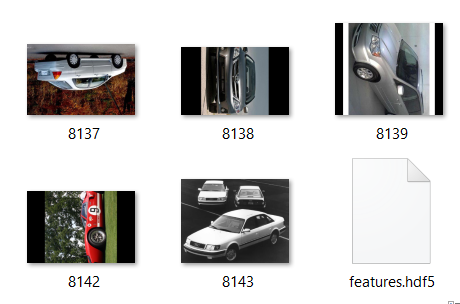
 
  WE EXTRACTED OUR FEATURES AND SAVED THEM IN A FILE TO USE IT FOR TRAIN MACHINE LEARNING ALGORITHMS

 FOR CLEARIFICATION, LET'S CHECK WHAT WE HAVE IN OUR FEATURES DATASET FILE

In [18]:
fe

In [22]:
print(fe.labels)

<Closed HDF5 dataset>


In [51]:
filename = "features.hdf5"

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key])) 
    data = list(f[a_group_key])
    ds_arr = f[a_group_key][()]
    
    b_group_key = list(f.keys())[1]
    label_1=f[b_group_key][()]
    
    c_group_key = list(f.keys())[2]
    label_2=f[c_group_key][()]

Keys: <KeysViewHDF5 ['features', 'label_names', 'labels']>
<class 'h5py._hl.dataset.Dataset'>


In [52]:
data

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.6431458]),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.14069581]),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.65064782,
        0.        ]),
 array([23.55382729,  0.        ,  0.        , ...,  0.        ,
        11.02316666,  0.        ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.        , 0.        , 8.88711739, ..., 0.        , 0.        ,
        0.        ]),
 array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 21.04888153]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0

In [53]:
len(data)

8144

In [54]:
ds_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
ds_arr.shape

(8144, 25088)

512 X 7 X = 25088

In [56]:
label_1

array([b'0', b'180', b'270', b'90'], dtype=object)

In [57]:
label_1.shape

(4,)

In [58]:
label_2

array([3, 3, 3, ..., 0, 2, 3])

In [59]:
label_2.shape

(8144,)